<a href="https://colab.research.google.com/github/NZodasic/Federated-Learning/blob/main/Federated_Learning_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mô phỏng 3 client có dữ liệu Non-IID, mỗi clent huấn liện cục bộ trong vài epoch, rồi server gom các trọng số lại bằng FedAvg - trung bình có trọng số theo kích thước dữ liệu

--> Lặp lại trong N vòng, đánh giá model trên toàn test set

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score

In [ ]:
np.random.seed(0)

In [ ]:
def sigmoid(x):
  return 1/(1 + np.exp(-x))

In [ ]:
def predict_proba(X, w, b):
  return sigmoid(X.dot(w) + b)

In [ ]:
def predict(X, w, b):
  return(predict_proba(X, w, b) >= 0.5).astype(int)

In [ ]:
def compute_loss(X, y, w, b):
  p = predict_proba(X, w, b)
  p = np.clip(p, 1e-9, 1 - 1e-9)
  return -np.mean(y * np.log(p) + (1-y) * np.log(1 - p))

In [ ]:
def local_train(X, y, w_init, b_init, lr=0.1, epochs=10, batch_size=16):
    """Train logistic regression locally on one client."""
    w = w_init.copy()
    b = b_init
    n = X.shape[0]
    losses = []
    for ep in range(epochs):
        perm = np.random.permutation(n)
        Xs, ys = X[perm], y[perm]
        for i in range(0, n, batch_size):
            xb, yb = Xs[i:i+batch_size], ys[i:i+batch_size]
            p = predict_proba(xb, w, b)
            grad_w = xb.T.dot(p - yb) / xb.shape[0]
            grad_b = np.mean(p - yb)
            w -= lr * grad_w
            b -= lr * grad_b
        losses.append(compute_loss(X, y, w, b))
    return w, b, losses

In [ ]:
# --- Create synthetic data for 3 clients (non-IID) ---
n_clients = 3
points_per_client = 200
centers = [(-2, -2), (2, -2), (0, 2)]
X_all, y_all = [], []

for i in range(n_clients):
    Xc, yc = make_blobs(
        n_samples=points_per_client,
        centers=[centers[i], (centers[i][0]+1.0, centers[i][1]+1.5)],
        cluster_std=0.8,
        random_state=i
    )
    yc = (yc % 2).astype(int)
    X_all.append(Xc)
    y_all.append(yc)

In [ ]:
# Global test set
X_test, y_test = make_blobs(
    n_samples=500,
    centers=[(-2,-2), (2,-2), (0,2), (1,1), (-1,1)],
    cluster_std=1.0,
    random_state=999
)
y_test = (y_test % 2).astype(int)

In [ ]:
# Initialize global model
dim = X_all[0].shape[1]
w_global = np.zeros(dim)
b_global = 0.0

# Federated parameters
rounds = 20
local_epochs = 5
lr = 0.1

In [ ]:
global_losses = []
client_losses_history = {i: [] for i in range(n_clients)}

In [ ]:
# --- Federated training ---
for r in range(rounds):
    local_weights, local_bs, local_sizes = [], [], []
    for i in range(n_clients):
        Xi, yi = X_all[i], y_all[i]
        w_local, b_local, losses = local_train(
            Xi, yi, w_global, b_global,
            lr=lr, epochs=local_epochs, batch_size=16
        )
        local_weights.append(w_local)
        local_bs.append(b_local)
        local_sizes.append(Xi.shape[0])
        client_losses_history[i].append(losses[-1])

    # FedAvg aggregation
    total_samples = sum(local_sizes)
    w_global = sum((n / total_samples) * w for w, n in zip(local_weights, local_sizes))
    b_global = sum((n / total_samples) * b for b, n in zip(local_bs, local_sizes))

    # Evaluate on test
    loss_g = compute_loss(X_test, y_test, w_global, b_global)
    global_losses.append(loss_g)

In [ ]:
# --- Evaluation ---
y_pred = predict(X_test, w_global, b_global)
acc = accuracy_score(y_test, y_pred)
print(f"Final test accuracy: {acc:.4f}")
print(f"Final test loss: {global_losses[-1]:.4f}")

Final test accuracy: 0.5420
Final test loss: 0.8775


In [ ]:
# --- Plots ---
xx, yy = np.meshgrid(np.linspace(-6, 6, 300), np.linspace(-6, 6, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
probs = predict_proba(grid, w_global, b_global).reshape(xx.shape)

plt.figure(figsize=(12,5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

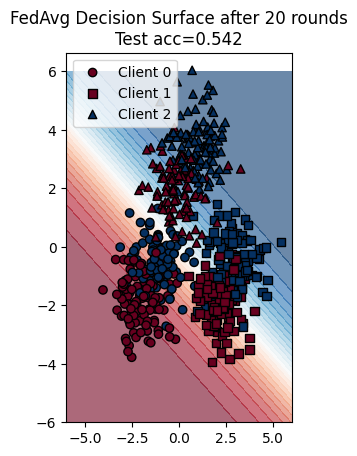

In [ ]:
# Decision surface
plt.subplot(1,2,1)
plt.contourf(xx, yy, probs, levels=25, cmap='RdBu', alpha=0.6)
markers = ['o', 's', '^']
for i in range(n_clients):
    plt.scatter(X_all[i][:,0], X_all[i][:,1], c=y_all[i],
                cmap='RdBu', edgecolor='k',
                marker=markers[i], label=f'Client {i}')
plt.title(f'FedAvg Decision Surface after {rounds} rounds\nTest acc={acc:.3f}')
plt.legend()

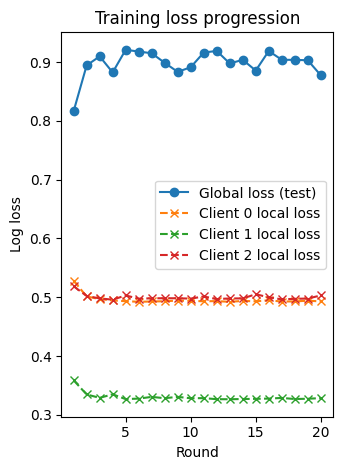

In [ ]:
# Loss progression
plt.subplot(1,2,2)
plt.plot(range(1, rounds+1), global_losses, marker='o', label='Global loss (test)')
for i in range(n_clients):
    plt.plot(range(1, rounds+1), client_losses_history[i], linestyle='--', marker='x',
             label=f'Client {i} local loss')
plt.xlabel('Round')
plt.ylabel('Log loss')
plt.title('Training loss progression')
plt.legend()

plt.tight_layout()
plt.show()